# Project 3 - Road Segmentation

### ETH Computational Intelligence Lab 2022 - Project 3

*Claim*: Some content are borrowed directly from the awesome Jupyter notebook prepared by TA last year.

The goal of the project is mainly on image segmentation, which is an important topic in Computer Vision. It has applications in autonomous driving, reconstruction and medical domain, etc.. In this project, you will focus on the road segmentation problem. **Given a set of RGB aerial images, we are formally asked to classify each 16x16 pixel patch as either containing road (1) or not (0).** 

You will find three relevant baselines, from classical statical method to some more sophisticated machine learning models for solving the problem. These baselines are in no sense optimal nor exhaustive, but can serve as a more or less starting point for the project.


# Data Exploration

In this project, you are provided with training set with 144 RGB images (**only!**) of resolution 400 x 400 px, and you are given two types of labels pixel-wise: 1 for road, and 0 otherwise. Notice that here, the patch labeling are not directly available, instead, you need to calculate the average of the label, that if at least 25% of pixels are labeled as road, then it would be considered as a "road patch". As for the test set, it consists of 144 images of the same resolution as the original image. 

For the purpose of illustration, we apply a **fixed training/validation split**. Notice that sticking a fixed split can significantly bias the validation metric, thus you may need to consider better validation strategy, and consider using all training images for the final submission. 

**We will now load* the datasets and visualize them briefly.**

***:** unfortunately, the Kaggle API is structured to send individual HTTP requests for each of the files requested. Since we need to download around 300 files from Kaggle, it is very likely that we would run into HTTP 429 errors. For this reason, it is best to **manually [download all](https://www.kaggle.com/c/cil-road-segmentation-2021/data) the datasets as a .zip file** from the website and then upload it to this notebook from the Files tab on the left of this page. Once this is done, we can proceed with the rest of the notebook.

If you are considering to use Colab for your project, it would be faster to save a copy of the datasets directly in your Google Drive folders (or in a git repo) and import them from there.

In [1]:
# some basic imports

import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image

In [3]:
# some constants
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

# unzip the dataset, split it and organize it in folders
if not os.path.isdir('validation'):  # make sure this has not been executed yet
  try:
          !unzip cil-road-segmentation-2022.zip
          os.chdir("cil-road-segmentation-2022")
          !mv training/training/* training
          !rm -rf training/training
          !mkdir validation
          !mkdir validation/images
          !mkdir validation/groundtruth
          for img in sample(glob("training/images/*.png"), VAL_SIZE):
            os.rename(img, img.replace('training', 'validation'))
            mask = img.replace('images', 'groundtruth')
            os.rename(mask, mask.replace('training', 'validation'))
  except Exception as e:
      print(e)
      print('Please upload a .zip file containing your datasets.')

Archive:  cil-road-segmentation-2022.zip
   creating: cil-road-segmentation-2022/
  inflating: __MACOSX/._cil-road-segmentation-2022  
  inflating: cil-road-segmentation-2022/.DS_Store  
  inflating: __MACOSX/cil-road-segmentation-2022/._.DS_Store  
   creating: cil-road-segmentation-2022/test/
  inflating: __MACOSX/cil-road-segmentation-2022/._test  
   creating: cil-road-segmentation-2022/training/
  inflating: __MACOSX/cil-road-segmentation-2022/._training  
  inflating: cil-road-segmentation-2022/mask_to_submission.py  
  inflating: __MACOSX/cil-road-segmentation-2022/._mask_to_submission.py  
  inflating: cil-road-segmentation-2022/submission_to_mask.py  
  inflating: __MACOSX/cil-road-segmentation-2022/._submission_to_mask.py  
  inflating: cil-road-segmentation-2022/test/.DS_Store  
  inflating: __MACOSX/cil-road-segmentation-2022/test/._.DS_Store  
   creating: cil-road-segmentation-2022/test/images/
  inflating: __MACOSX/cil-road-segmentation-2022/test/._images  
  inflating: 

  inflating: cil-road-segmentation-2022/test/images/satimage_218.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_218.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_219.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_219.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_231.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_231.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_225.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_225.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_184.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_184.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_190.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_190.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_147.png  
  inflating

  inflating: cil-road-segmentation-2022/test/images/satimage_201.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_201.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_229.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_229.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_188.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_188.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_163.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_163.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_177.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_177.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_149.png  
  inflating: __MACOSX/cil-road-segmentation-2022/test/images/._satimage_149.png  
  inflating: cil-road-segmentation-2022/test/images/satimage_161.png  
  inflating

  inflating: cil-road-segmentation-2022/training/images/satimage_90.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_90.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_47.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_47.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_53.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_53.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_108.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_108.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_134.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_134.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_120.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_120.png  
  inflating: cil-road-segmentation-2022/

  inflating: cil-road-segmentation-2022/training/images/satimage_17.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_17.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_16.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_16.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_14.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_14.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_28.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_28.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_29.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_29.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_15.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_15.png  
  inflating: cil-road-segmentation-2022/traini

  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_98.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_59.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_59.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_71.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_71.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_65.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_65.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_102.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_102.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_116.png  
  inflating: __MACOSX/cil-road-segmentation-2022/training/images/._satimage_116.png  
  inflating: cil-road-segmentation-2022/training/images/satimage_3.png  
  inflating: __MACOSX/cil-road-segmentation

mv: cannot stat 'training/training/*': No such file or directory


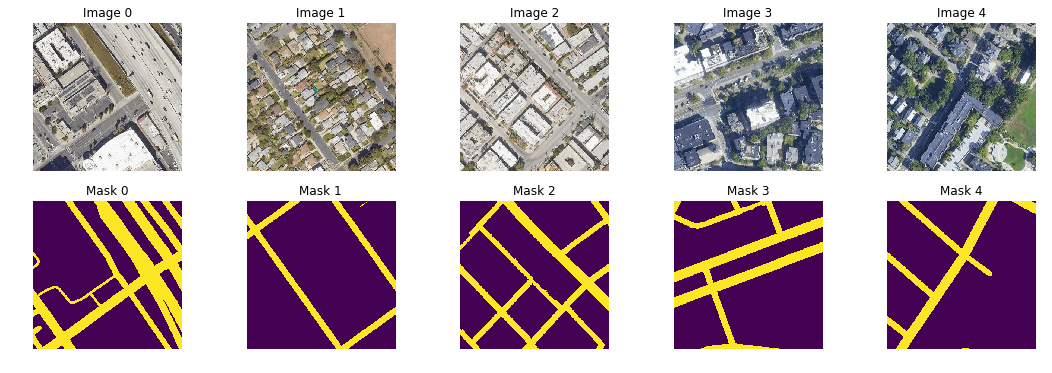

In [6]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.


def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()
    

# paths to training and validation datasets
train_path = 'training'
val_path = 'validation'

train_images = load_all_from_path(os.path.join(train_path, 'images'))
train_masks = load_all_from_path(os.path.join(train_path, 'groundtruth'))
val_images = load_all_from_path(os.path.join(val_path, 'images'))
val_masks = load_all_from_path(os.path.join(val_path, 'groundtruth'))

# visualize a few images from the training set
show_first_n(train_images, train_masks)

We have mentioned that our task can also be seen as a classification problem. Let us visualize how each image can be broken up in patches and how we can compute labels from groundtruth masks.

In [7]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    images = images[:,:,:,:3]
    
    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE
    
    patches = images.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=(18.5, 18.5))
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


# extract all patches and visualize those from the first image
train_patches, train_labels = image_to_patches(train_images, train_masks)
val_patches, val_labels = image_to_patches(val_images, val_masks)

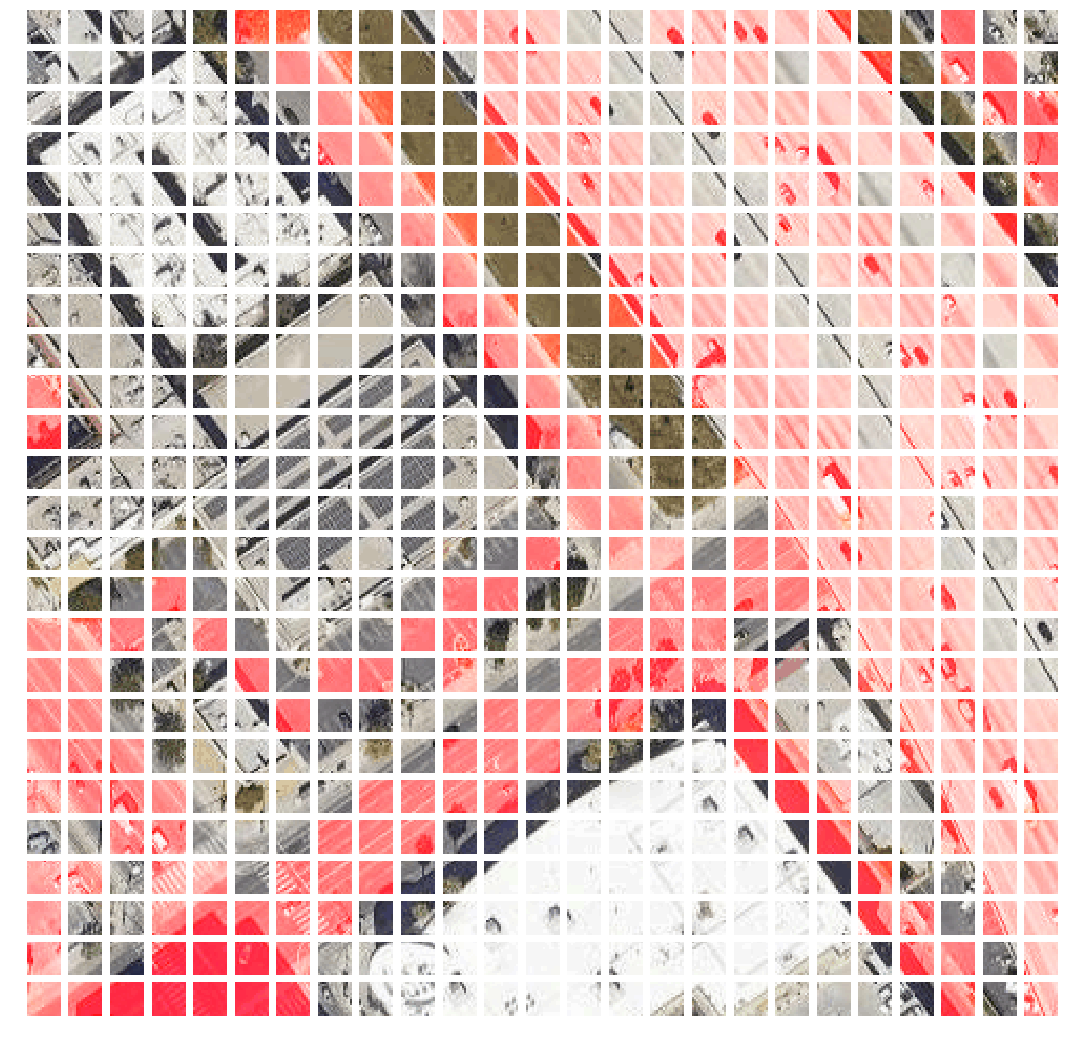

In [8]:
# the first image is broken up in the first 25*25 patches
show_patched_image(train_patches[:25*25], train_labels[:25*25])

It appears that the classification task might be **largely unbalanced**. Let us verify it.

In [9]:
print("{0:0.2f}".format(sum(train_labels) / len(train_labels) * 100) + '% of training patches are labeled as 1.')
print("{0:0.2f}".format(sum(val_labels) / len(val_labels) * 100) + '% of validation patches are labeled as 1.')

24.74% of training patches are labeled as 1.
23.54% of validation patches are labeled as 1.


This means that a trivial classifier that always assigns the majority class (0) to each sample would already reach an accuracy of about ~75%. We will observe that reaching such accuracy is already quite a challenge. While entirely possible, it will require many ideas that we will only be able to touch upon.


# Method 1 - Logistic Regression

Considering the problem the road segmentation, one of the first thing you can observe is that the color of roads seems to be **uniform** and **consistent**. In this case, it might make sense to consider using this as a deciding criterior. In fact, prior to the success of neural networks, Computer Vision largely relied on hand-crafted features or hand-designed filters.


From each patch we can extract a vector of 6 features representing the **average value** and the **variance** of each color channel across the patch. We can then train a simple [logistic regression](https://en.wikipedia.org/wiki/Logistic_regression) model to assign a label to each patch. More formally, we define $x_i$ to be the feature vector of observation $i$ which is designed to be $[\mu_i, \sigma_i]^\top\in \mathbb{R}^6$ in our case, and define $y_i$ to be the label of each patch. Then we model the probability of a patch to contain road surface as 
$$P(y_i=1) = h(x_i) = \frac{1}{1 + e^{-x_i^\top \theta}}$$

where $\theta$ are parameters to be optimized.

Then we use the negative log likehood or, equivalently, a cross entropy loss function as the loss function, and we can solve the optimal weight vector $\theta$ by:

$$\theta^* = \arg\min{\frac{1}{n} \sum_{i=0}^{n-1}(-y_i \log{(h(x_i))} - (1-y_i)\log{(1- h(x_i))})}$$

In [10]:
def extract_features(x):
    # extracts features from each patch
    return np.concatenate([np.mean(x, (-2, -3)), np.var(x, (-2,-3))], axis=-1)

from sklearn.linear_model import LogisticRegression

train_path = 'training'
val_path = 'validation'

train_images = load_all_from_path(os.path.join(train_path, 'images'))
train_masks = load_all_from_path(os.path.join(train_path, 'groundtruth'))
val_images = load_all_from_path(os.path.join(val_path, 'images'))
val_masks = load_all_from_path(os.path.join(val_path, 'groundtruth'))
train_patches, train_labels = image_to_patches(train_images, train_masks)
val_patches, val_labels = image_to_patches(val_images, val_masks)

x_train = extract_features(train_patches)
x_val = extract_features(val_patches)
clf = LogisticRegression(class_weight='balanced').fit(x_train, train_labels)
print(f'Training accuracy: {clf.score(x_train, train_labels)}')
print(f'Validation accuracy: {clf.score(x_val, val_labels)}')

Training accuracy: 0.6017432835820895
Validation accuracy: 0.62832


We can also visualize how an image from the training set is segmented.


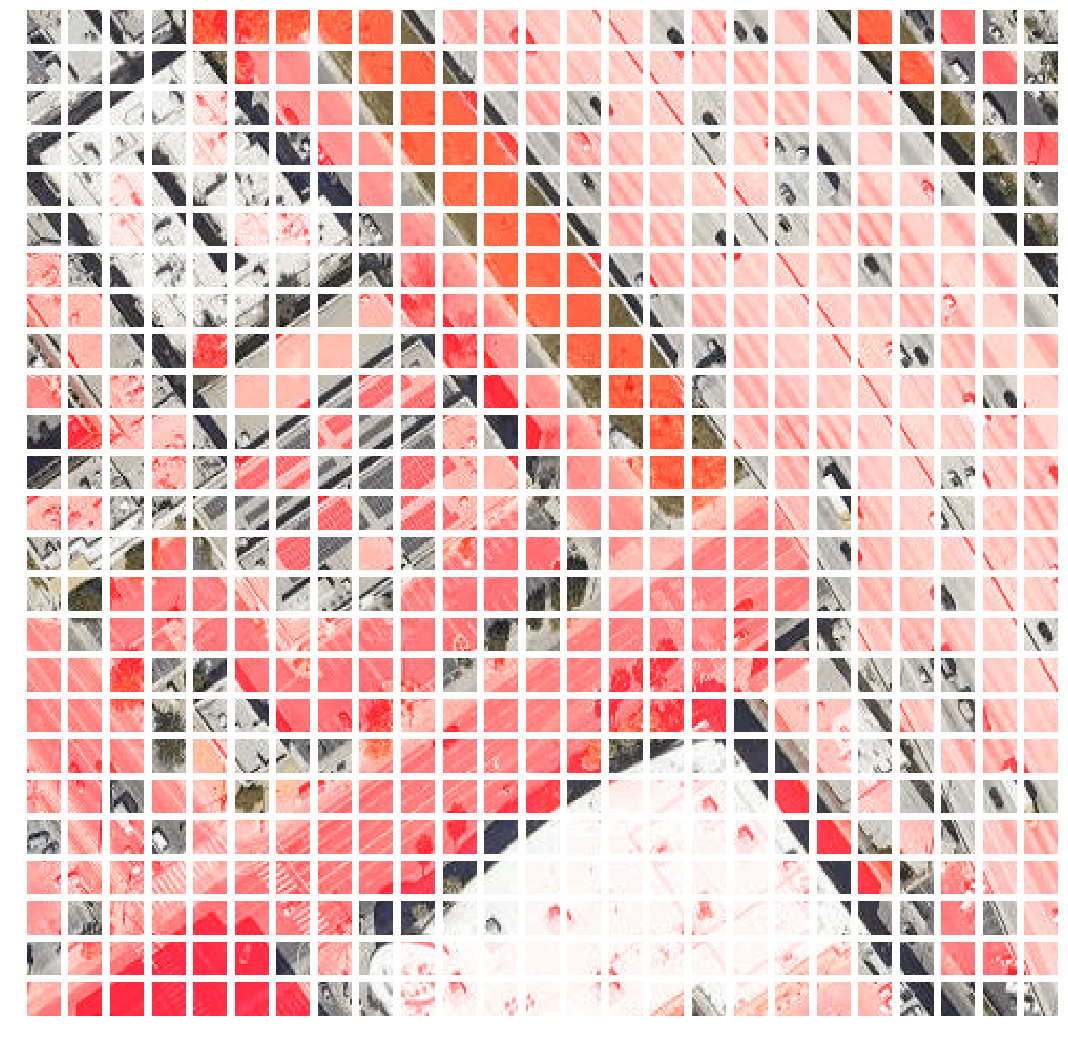

In [11]:
show_patched_image(train_patches[:25*25], clf.predict(x_train[:25*25]))

Finally, let us compute predictions on test images. The code in this cell is adapted from `mask_to_submission.py`.

In [12]:
def create_submission(labels, test_filenames, submission_filename):
    test_path='test/images'
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

test_path = 'test/images'
test_filenames = sorted(glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
test_patches = image_to_patches(test_images)
x_test = extract_features(test_patches)
test_pred = clf.predict(x_test).reshape(-1, test_images.shape[1] // PATCH_SIZE, test_images.shape[2] // PATCH_SIZE)
create_submission(test_pred, test_filenames, submission_filename='logreg_submission.csv')

allzero = np.zeros_like(test_pred)
create_submission(allzero, test_filenames, submission_filename='allzero_submission.csv')


By submitting this .csv to Kaggle, we should get a public score of around 0.60. This is not so ideal considering that an all-zero prediction get a public score of over 0.75.


This method is producing many false positives and has **obvious drawbacks**. Spacial patterns in the image are completely ignored and occlusion cannot be dealt with. Moreover, the method required us to manually define interesting features. While crafting better features can surely improve the performance of our classifier, our method would require to be redesigned from scratch to deal with other segmentation tasks. We will then turn to methods that overcome these limitations.

# Convolutional Neural Networks

You might have alreadly learnt how the rapid development of convolutional neural network transformed the field of Computer Vision profoundly. Relevant materials can be found in lecture and corresponding tutorials. So, to avoid overlapping of content, they will be omitted here.

For the purpose of this notebook, it is sufficient to remark that CNNs are capable of **automatically extracting useful features** from images and can approximate very complex functions. This alone will bring a great improvement over the previous approach.

We will first introduce some utility functions for loading and visualizing data.


In [15]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)


class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, path, device, use_patches=True, resize_to=(400, 400)):
        self.path = path
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = load_all_from_path(os.path.join(self.path, 'images'))[:,:,:,:3]
        self.y = load_all_from_path(os.path.join(self.path, 'groundtruth'))
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))
    
    def __len__(self):
        return self.n_samples


def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

Here we define a general training loop.

In [16]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)
                
                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [17]:
# The training loop also logs metrics to tensorboard. They can be visualized in real time by uncommenting the next two lines:

# %load_ext tensorboard
# %tensorboard --logdir ./tensorboard

# Tensorboard can also be used to log images, which can be great for visually inspecting your output.

# Method 2 - Patch CNN
As mentioned before, CNN is powerful in terms of feature extraction. With such knowledge, the first improvment we can make is to replace the original manual-designed feature (mean and variance) by CNN feature. 

The structure of the network used is illustrated below. You can view this method as training an end-to-end network predicting on image of size 16 x 16 and classifying it being a road image or not.


It is very advisable that the notebook has access to a GPU to accelerate the training procedure. You can enable a GPU backend by clicking on Runtime -> Change runtime type -> GPU. You can check the hardware you are assigned with
```
!nvidia-smi
```
This notebook was tested with a GPU with 8G memory, but in case of Out Of Memory errors, lowering the batch size may help.

![]( 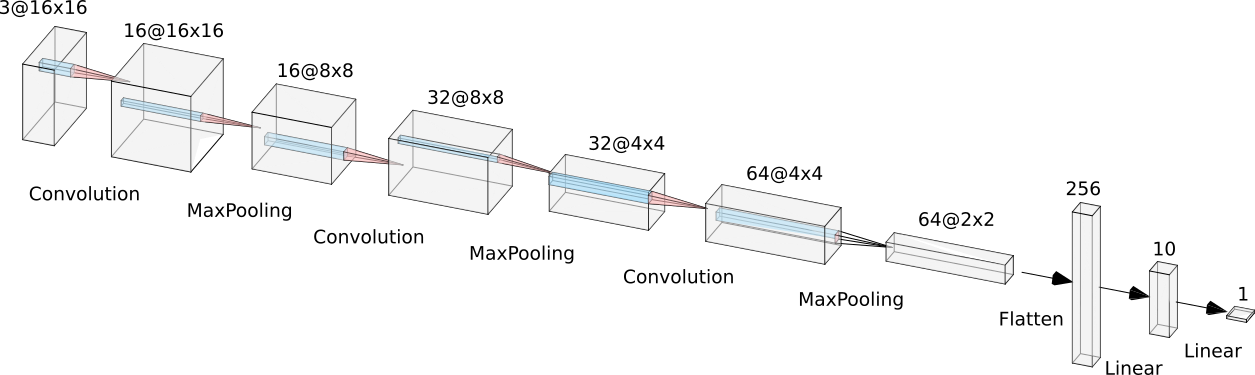)

In [18]:
class PatchCNN(nn.Module):
    # simple CNN for classification of patches
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(16),
                                 nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(32),
                                 nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
                                 nn.ReLU(),
                                 nn.MaxPool2d(2, 2),
                                 nn.BatchNorm2d(64),
                                 nn.Dropout(0.5),
                                 nn.Flatten(),
                                 nn.Linear(256, 10),
                                 nn.ReLU(),
                                 nn.Dropout(0.5),
                                 nn.Linear(10, 1),
                                 nn.Sigmoid())

    def forward(self, x):
        return self.net(x)

def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

Epoch 1/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4784046736289197
  	- val_loss = 0.46245144977085834
  	- acc = 0.7869865317982951
  	- val_acc = 0.7936751738838528
 


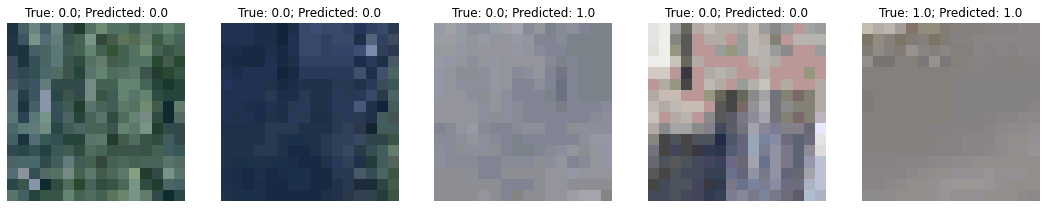

Epoch 2/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4515320090327676
  	- val_loss = 0.44690975330877997
  	- acc = 0.7948206251061808
  	- val_acc = 0.8000009845996249
 


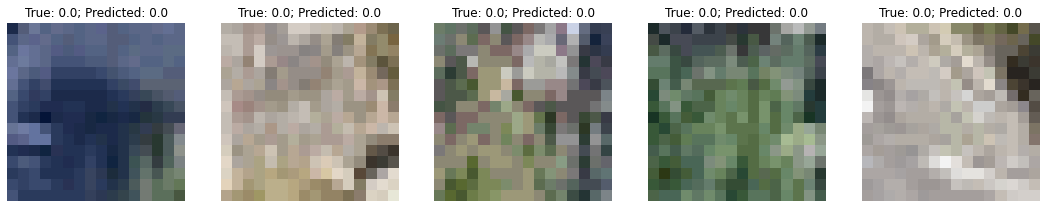

Epoch 3/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4411267504917355
  	- val_loss = 0.44044450918833417
  	- acc = 0.8003959605074304
  	- val_acc = 0.7840756929439047
 


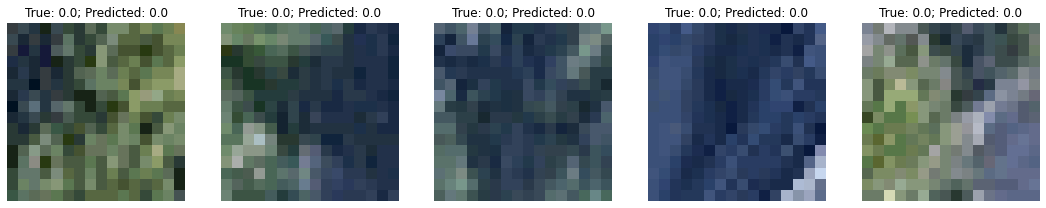

Epoch 4/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.43294586844331634
  	- val_loss = 0.42132050921951514
  	- acc = 0.8032512955778227
  	- val_acc = 0.8054259220759074
 


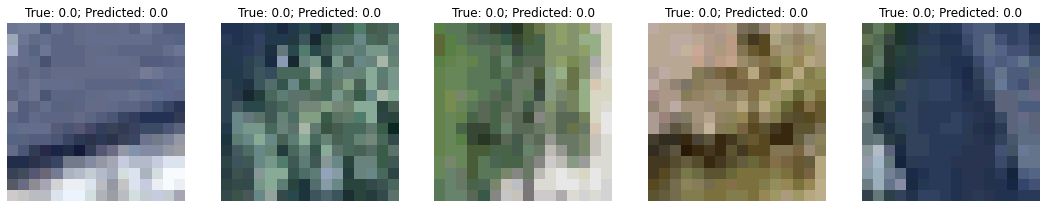

Epoch 5/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4283694264456982
  	- val_loss = 0.4243246459442636
  	- acc = 0.8047492668384643
  	- val_acc = 0.8067452346069225
 


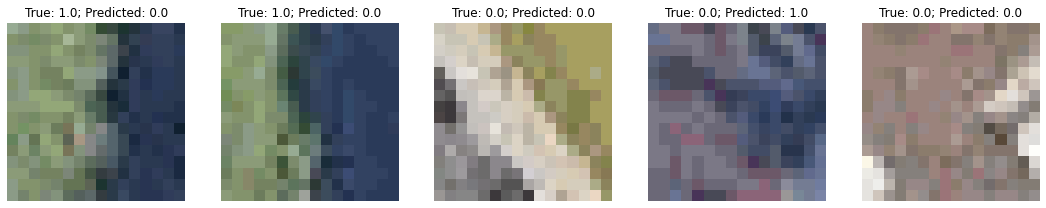

Epoch 6/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.42467690279164655
  	- val_loss = 0.4251907580140708
  	- acc = 0.8077939196834414
  	- val_acc = 0.7982533867808356
 


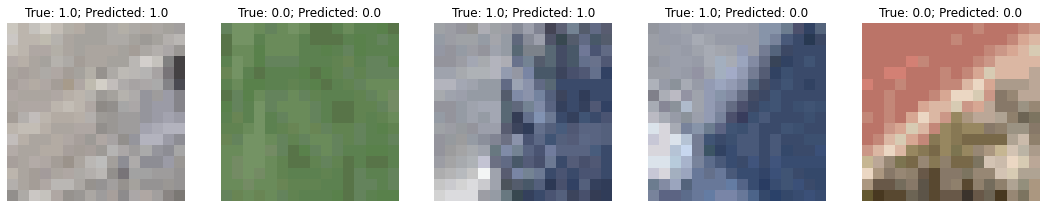

Epoch 7/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.42179152275633625
  	- val_loss = 0.40353687258734217
  	- acc = 0.8078619636888579
  	- val_acc = 0.8181710778803065
 


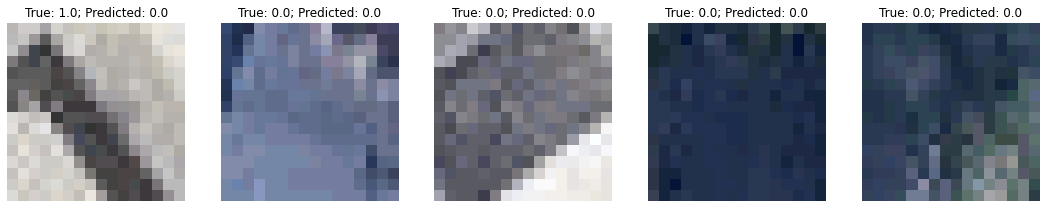

Epoch 8/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.418814846849817
  	- val_loss = 0.4309805316337641
  	- acc = 0.809718986008111
  	- val_acc = 0.804406900336777
 


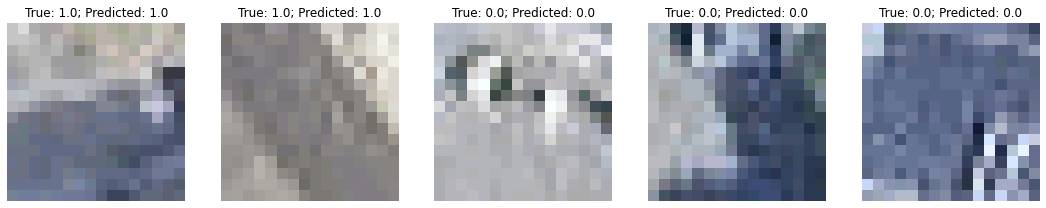

Epoch 9/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4143577835221929
  	- val_loss = 0.4124937640584033
  	- acc = 0.8120688875829141
  	- val_acc = 0.8127855235251827
 


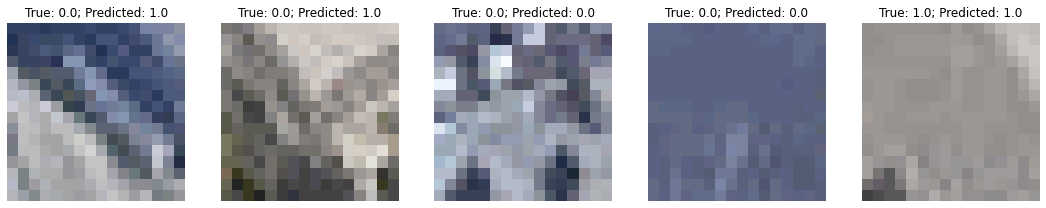

Epoch 10/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.41285547557778246
  	- val_loss = 0.4060037567995597
  	- acc = 0.813239444334676
  	- val_acc = 0.8129725896793863
 


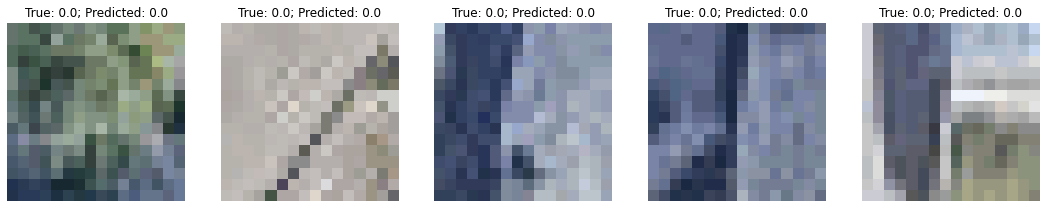

Epoch 11/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.40879974538885705
  	- val_loss = 0.4124022311922433
  	- acc = 0.814806714959032
  	- val_acc = 0.8127707545308099
 


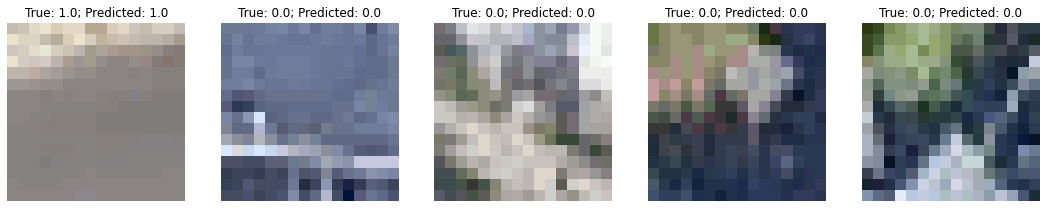

Epoch 12/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4066128845759264
  	- val_loss = 0.3915332033150438
  	- acc = 0.8159074702600795
  	- val_acc = 0.8240833731665127
 


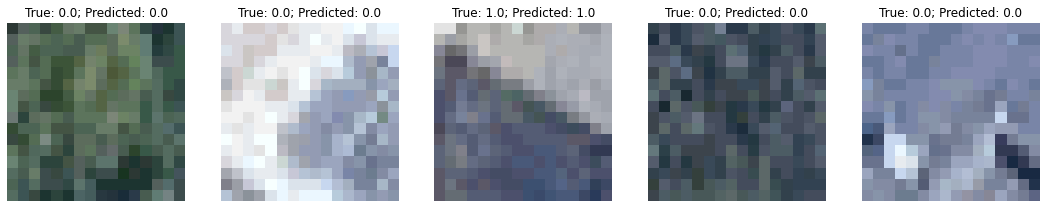

Epoch 13/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4035150334121674
  	- val_loss = 0.410444769738377
  	- acc = 0.8177092539043878
  	- val_acc = 0.8043182898258817
 


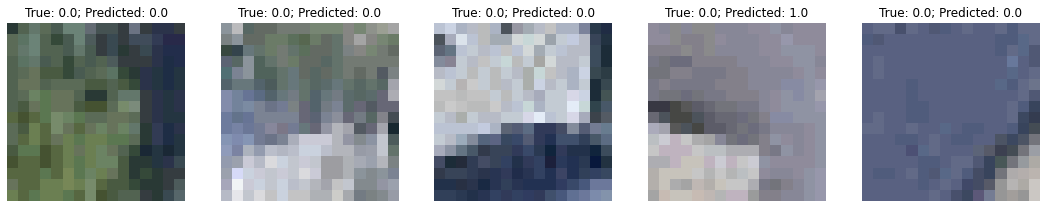

Epoch 14/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.4015221817756262
  	- val_loss = 0.40247272451718646
  	- acc = 0.8191763417927299
  	- val_acc = 0.8108360905578171
 


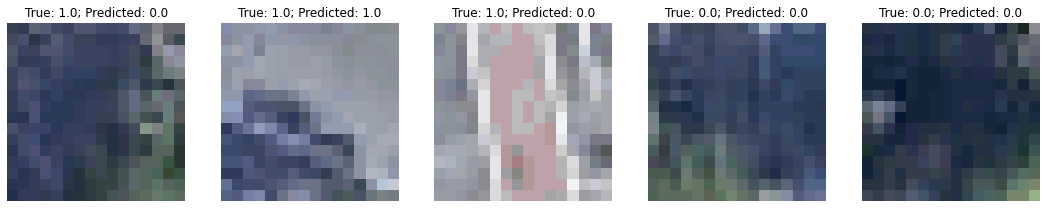

Epoch 15/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.39916421780436057
  	- val_loss = 0.3944147855475329
  	- acc = 0.8191582636570367
  	- val_acc = 0.8197168405505194
 


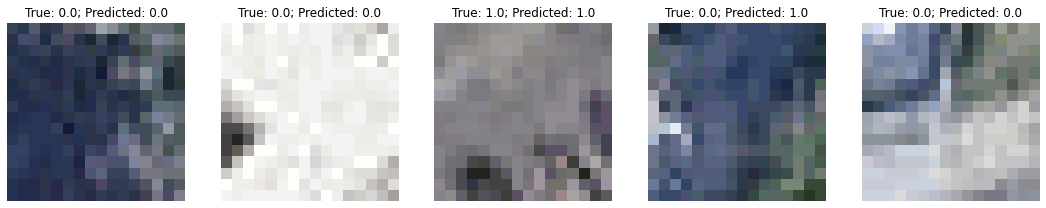

Epoch 16/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.3980397496636458
  	- val_loss = 0.3997533066549163
  	- acc = 0.8204747006649108
  	- val_acc = 0.8097875316937765
 


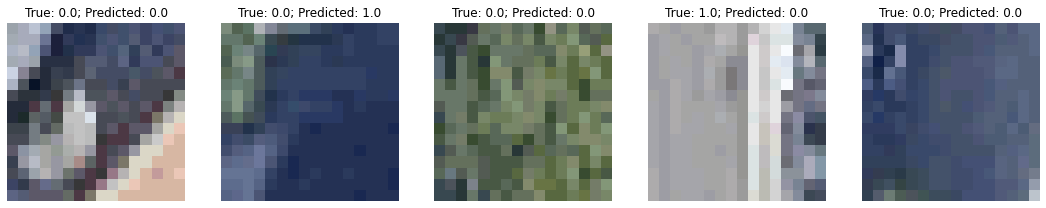

Epoch 17/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.3966242741412065
  	- val_loss = 0.3952746011208797
  	- acc = 0.8218441165338352
  	- val_acc = 0.8225966838822849
 


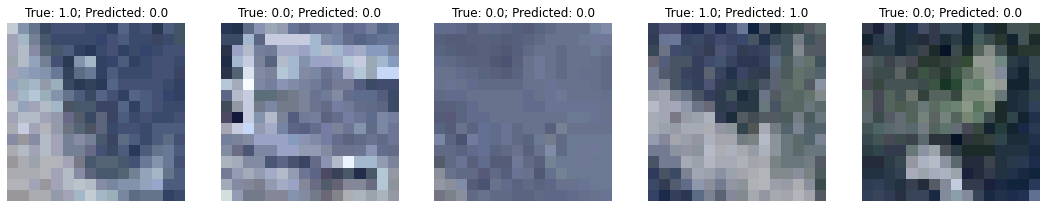

Epoch 18/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.3970424177609091
  	- val_loss = 0.39476829378501227
  	- acc = 0.8221383877626555
  	- val_acc = 0.819224558878636
 


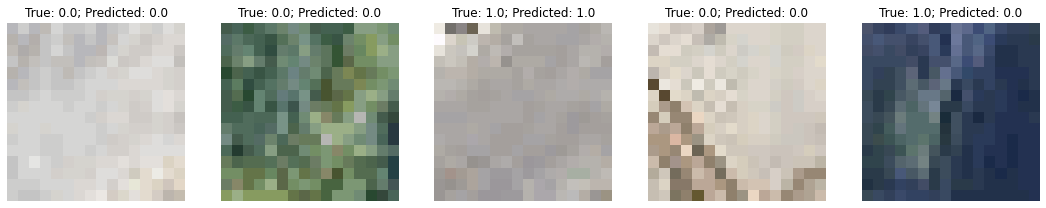

Epoch 19/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.3935362497183282
  	- val_loss = 0.38503788433213165
  	- acc = 0.8224620360089099
  	- val_acc = 0.8284597509149192
 


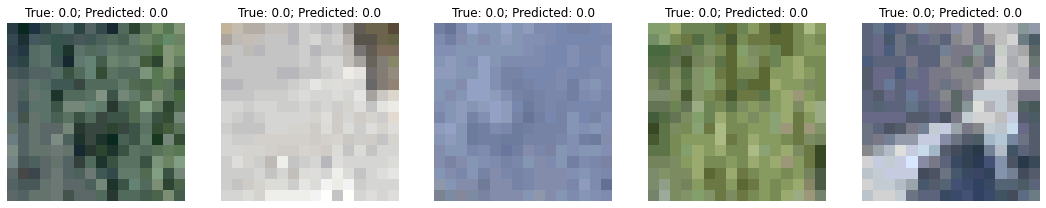

Epoch 20/20:   0%|          | 0/635 [00:00<?, ?it/s]

	- loss = 0.39242743624476933
  	- val_loss = 0.39418139794598456
  	- acc = 0.8229390968487957
  	- val_acc = 0.8172997400380563
 


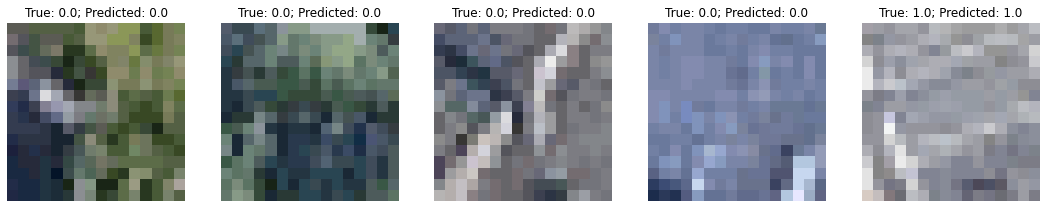

Finished Training


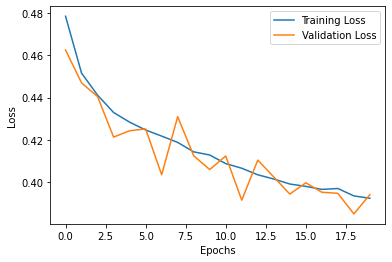

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # automatically select device
train_dataset = ImageDataset('training', device)
val_dataset = ImageDataset('validation', device)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)
model = PatchCNN().to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 20
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)

In [52]:
# predict on test set
test_filenames = sorted(glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
test_images = test_images[:, :, :, :3]
test_patches = np.moveaxis(image_to_patches(test_images), -1, 1)  # HWC to CHW
test_patches = np.reshape(test_patches, (25, -1, 3, PATCH_SIZE, PATCH_SIZE))  # split in batches for memory constraints
test_pred = [model(np_to_tensor(batch, device)).detach().cpu().numpy() for batch in test_patches]
test_pred = np.concatenate(test_pred, 0)
test_pred = np.round(test_pred.reshape(test_images.shape[0], test_images.shape[1] // PATCH_SIZE, test_images.shape[1] // PATCH_SIZE))
create_submission(test_pred, test_filenames, submission_filename='cnn_submission.csv')

This classifier is able to reach much better accuracy (public score around 0.83 on Kaggle), which can be further improved by tuning the architecture and hyperparameters. But there is also some obvious drawback of this method, namely, the network has access to local information only. As roads usually cross several patches, neighboring patches provide addtional information for the current patch. This observation inspires the last method we will introduce here.

# Method 3 - U-Net

The introduction of U-Net can be found in material of Tutorial 9. U-Net has been widely deployed in the field of Computer Vision. Here, instead of considering the problem patch-wise, we predict **pixel-wise label** for each image. Our model will receive a large image covering multiple patches and output a single channel greyscale image at the same resolution. We will then use our brightness-based heuristic to transform the output into labels.

Note: our implementation differs from the original by introducing Batch Normalization layers and padded convolutions to avoid cropping features.



![]( 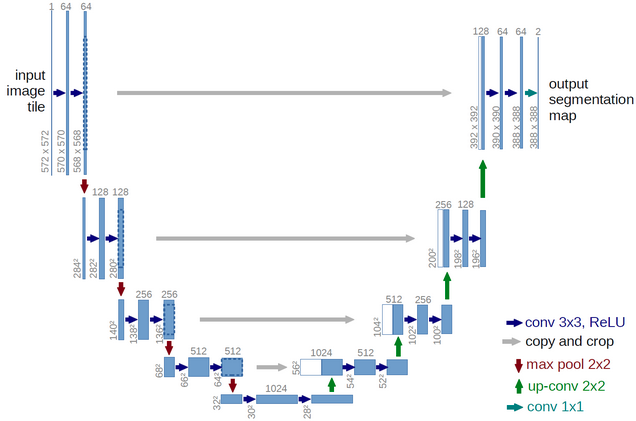)

In [19]:
class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU())

    def forward(self, x):
        return self.block(x)

        
class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel


def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset('training', device, use_patches=False, resize_to=(384, 384))
val_dataset = ImageDataset('validation', device, use_patches=False, resize_to=(384, 384))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)
model = UNet().to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 35
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)


/home/samuki/.local/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [45]:
# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0]
size = test_images.shape[1:3]
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = test_images[:, :, :, :3]
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)
test_pred = [model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape
# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')

This final model can get a public score about 0.86 for the public score, which further improves the result of patch CNN. 

While it introduces some very important ideas, it is by no means close to state-of-the-art performance, and it can be completely outclassed by more powerful and newer methods. Moreover, many different elements are needed to reach good accuracy, and the right architecture is only one of them. Nevertheless, U-Net represents a good starting point for your project.

# Tips

In conclusion, we will go over some more or less specific tips for your project.

## On Road Segmentation
When you are completely new to a field, an efficient way to get yourself familar to it is to start from reading **overview**. We list several examples below:

* [Deep Learning Approaches Applied to Remote Sensing Datasets for Road Extraction: A State-Of-The-Art Review](https://www.mdpi.com/2072-4292/12/9/1444/htm)
* [Image Segmentation Using Deep Learning: A Survey](https://arxiv.org/pdf/2001.05566.pdf). This is a survey on the more general image segmentation problem

[**Transformer**](https://arxiv.org/pdf/1706.03762.pdf) has recently become a very popular choice in the task of image segmentation and boosted performances in many tasks. Some literatures for general task of image segmentation has been listed here. Notice that since Transformer is intrinsically data hungary, you should consider how to handle this deficiency like considering a pretrained model

* [Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective with Transformers](https://openaccess.thecvf.com/content/CVPR2021/papers/Zheng_Rethinking_Semantic_Segmentation_From_a_Sequence-to-Sequence_Perspective_With_Transformers_CVPR_2021_paper.pdf)
* [Segmenter: Transformer for Semantic Segmentation](https://arxiv.org/pdf/2105.05633.pdf)
* [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://proceedings.neurips.cc/paper/2021/file/64f1f27bf1b4ec22924fd0acb550c235-Paper.pdf)

For the concrete task of **road segmentation**, you can refer to following literatures 

* [RoadTracer: Automatic Extraction of Road Networks from Aerial Images](https://openaccess.thecvf.com/content_cvpr_2018/papers/Bastani_RoadTracer_Automatic_Extraction_CVPR_2018_paper.pdf)
* [Road Detection and Segmentation from Aerial Images Using a CNN Based System](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8441366)
* [Learning Aerial Image Segmentation from Online Maps](https://arxiv.org/abs/1707.06879)
* [Learning to Label Aerial Images from Noisy Data](https://www.cs.toronto.edu/~vmnih/docs/noisy_maps.pdf)
* [DeepGlobe 2018: A Challenge to Parse the Earth through Satellite Images](https://www.researchgate.net/publication/325215555_DeepGlobe_2018_A_Challenge_to_Parse_the_Earth_through_Satellite_Images)

Tutorial 9 also gives a good introduction on the task of segmentation, you can refer to it for more detailed information.

## On CNNs

Research on CNNs has grown at an intense pace  in recent years. Listing the most influential papers in this context would be a very hard task, so we will just cite a few important works with no claim of completeness. While some of the presented models might not be directly applicable, they introduce interesting ideas.

* [ResNet](https://arxiv.org/abs/1512.03385)
* [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf)
* [DeepLab v1](https://arxiv.org/abs/1606.00915) (v2, v3 and v3+ also exist)
* [PsPNet](https://arxiv.org/abs/1612.01105)

## Concrete Tips
* The point of this project is not about topping the leader board in Kaggle competition, but is to have some novel and interesting ideas on this specific task.

* Besides coming up with interesting ideas, it is also important to present them well, since 70% your score is based on your report. You can use [this](http://www.da.inf.ethz.ch/teaching/2020/CIL/files/cil_sample.zip) as the template.

* Think about how task of road segmentation differs from general segmentation task may help you to generate some ideas.

* Explore the data in depth but **avoid information leakage**.

* Two fundamentals topics were skipped in this notebook, namely pre-processing and post-processing. Both are crucial to this project.

* **Hyperparameter tuning** is a tedious process, but it can have massive impact on your work. For general advices on this topic, you can refer to Tutorial 9 or the book [*deep learning*](https://www.deeplearningbook.org/).

* You do not have to reinvent the wheel and code everything from scratch. Open source implementations of existing models can be a good starting point. On the other hand, coding your own models can be helpful to you as a learner.

* While they might not be interesting for reviewers, methods like ensembling can help you in the competitive part.

* **Be clear about your contribution and choose baselines accordingly.**

# Getting started with the project

### Google Colab:

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with 
- Zero configuration required
- Free access to GPUs
- Easy sharing

[Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more.

### ETH clusters

ETH provides access to the [Euler](https://scicomp.ethz.ch/wiki/Euler) and [Leonhard](https://scicomp.ethz.ch/wiki/Leonhard) cluster (see also [Getting started with clusters](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys)).

To start:
- Open [VPN](https://www.isg.inf.ethz.ch/Main/ServicesNetworkVPN)!
- [Setup SSH keys](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys) (only need to do that once).
- Can even run jupyter-notebooks via [this](https://scicomp.ethz.ch/wiki/Jupyter_on_Euler_and_Leonhard_Open). If you want to run with a GPU may need to change the file accordingly (line 64: "python_cpu/3.6.4" -> "python_gpu/x.x.x" see [this](https://scicomp.ethz.ch/wiki/Python_on_Leonhard) for available versions, line 139 to request a GPU change rusage demands). To see tensorboard results you can mount the remote directory
```
sshfs <ethz-username>@<cluster-hostname>:<directory>
```
and run tensorboard locally 
```
tensorboard --logdir <directory>
```